In [3]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from statsmodels.tsa.api import ExponentialSmoothing,SimpleExpSmoothing,Holt
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

In [4]:
sales_main=pd.read_csv("gold_monthly_csv.csv")
sales_main

,Date,Price
0,1950-01,34.730
1,1950-02,34.730
2,1950-03,34.730
3,1950-04,34.730
4,1950-05,34.730
...,...,...
842,2020-03,1593.764
843,2020-04,1680.030
844,2020-05,1715.697
845,2020-06,1734.032


In [9]:
sales_main.shape
date=pd.date_range(start='1/1/1950',end='8/1/2020',freq="M")

In [10]:
sales_main["month"]=date
sales_main.drop("Date",axis=1,inplace=True)
sales_main=sales_main.set_index("month")
sales_main.head()

,Price
month,
1950-01-31,34.73
1950-02-28,34.73
1950-03-31,34.73
1950-04-30,34.73
1950-05-31,34.73


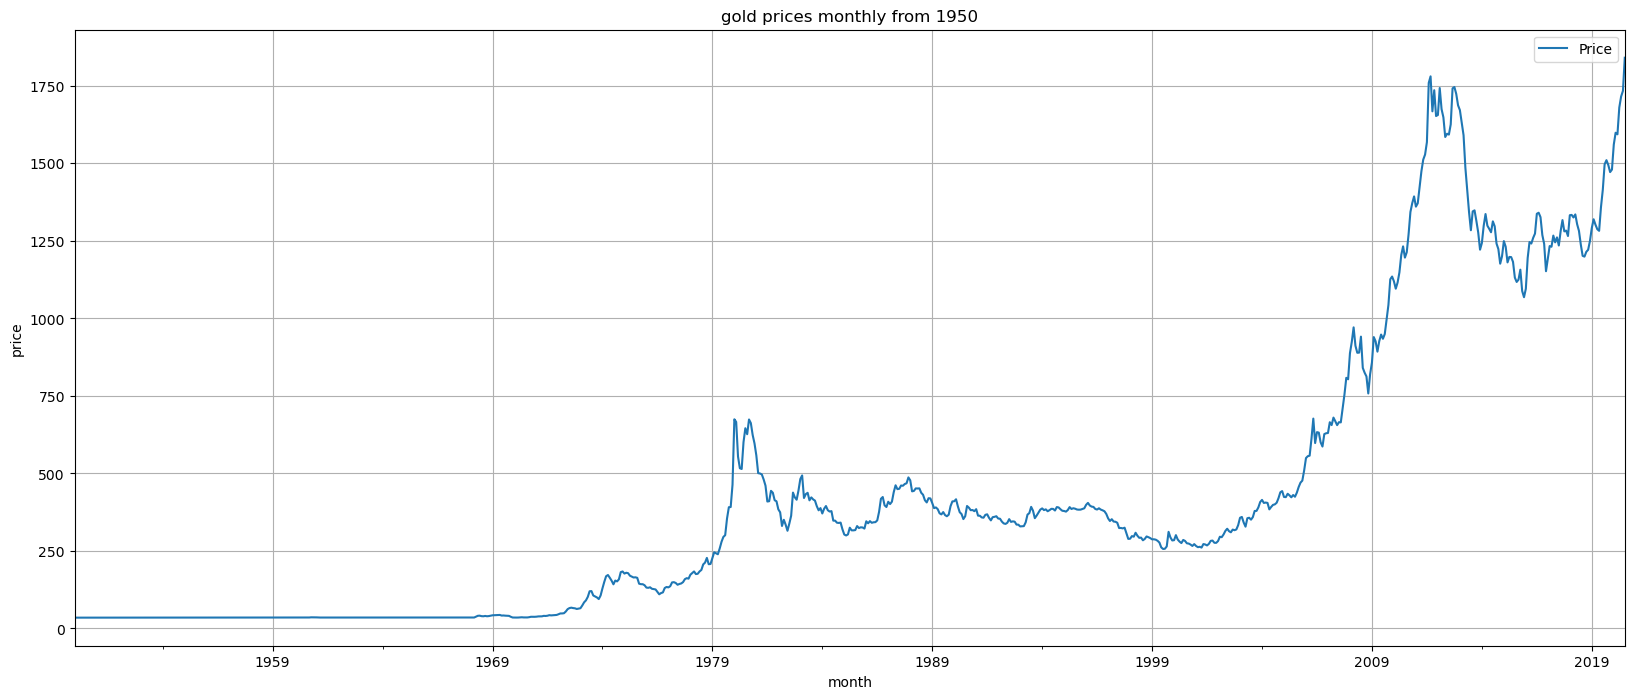

In [16]:
sales_main.plot(figsize=(20,8))
plt.title("gold prices monthly from 1950")
plt.xlabel("month")
plt.ylabel("price")
plt.grid()
plt.show()

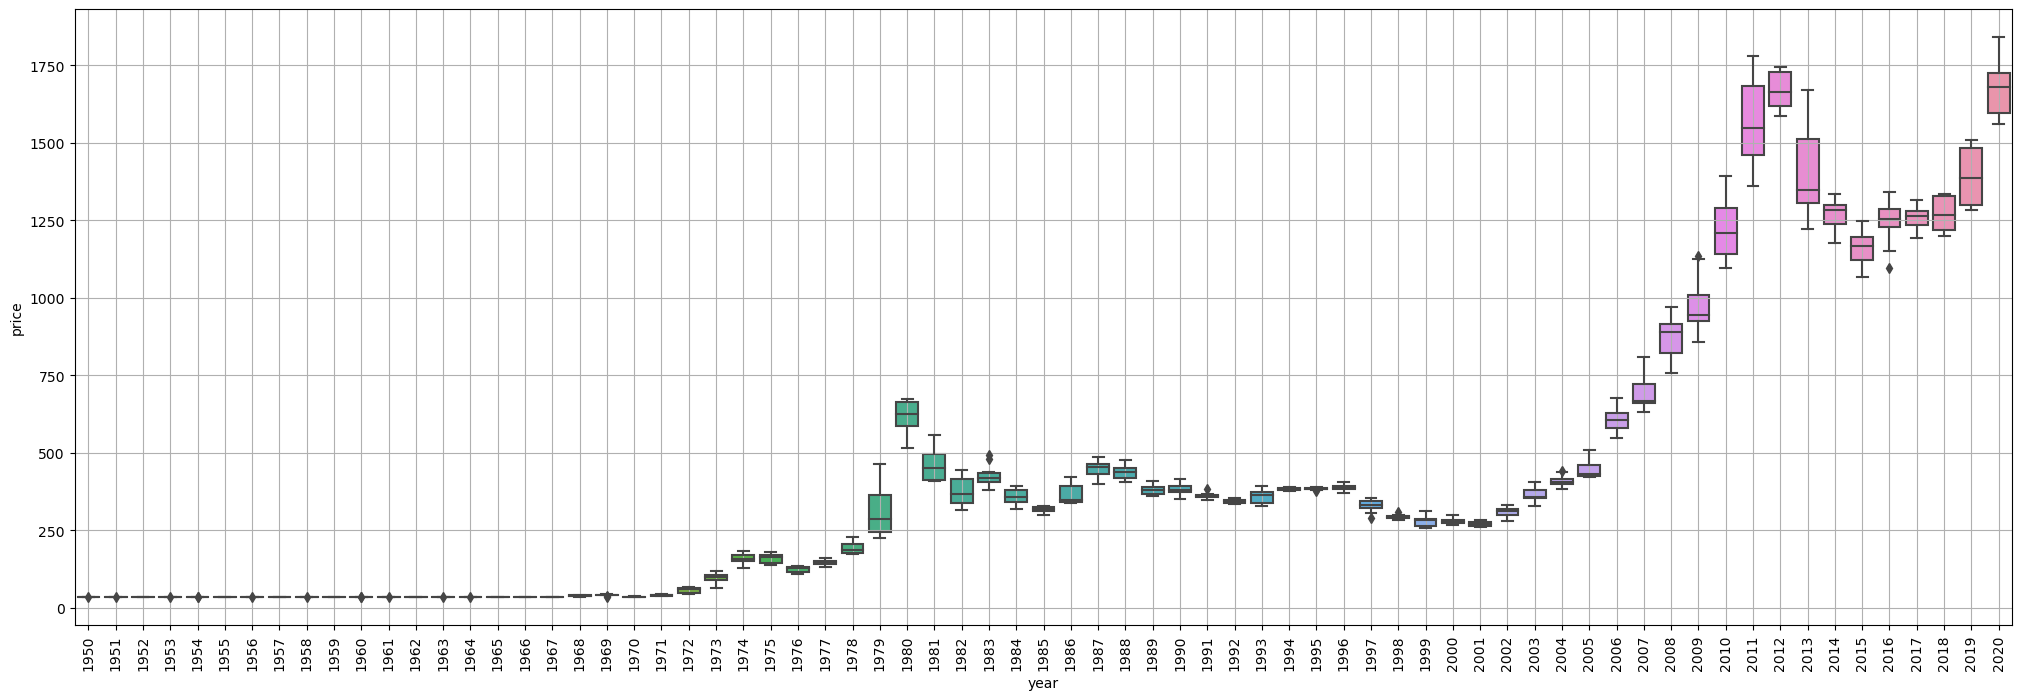

In [21]:
_,ax=plt.subplots(figsize=(25,8))
sns.boxplot(x=sales_main.index.year,y=sales_main.values[:,0],ax=ax)
plt.xticks(rotation="vertical")
plt.xlabel("year")
plt.ylabel("price")
plt.grid()
plt.show()

In [22]:
from statsmodels.graphics.tsaplots import month_plot

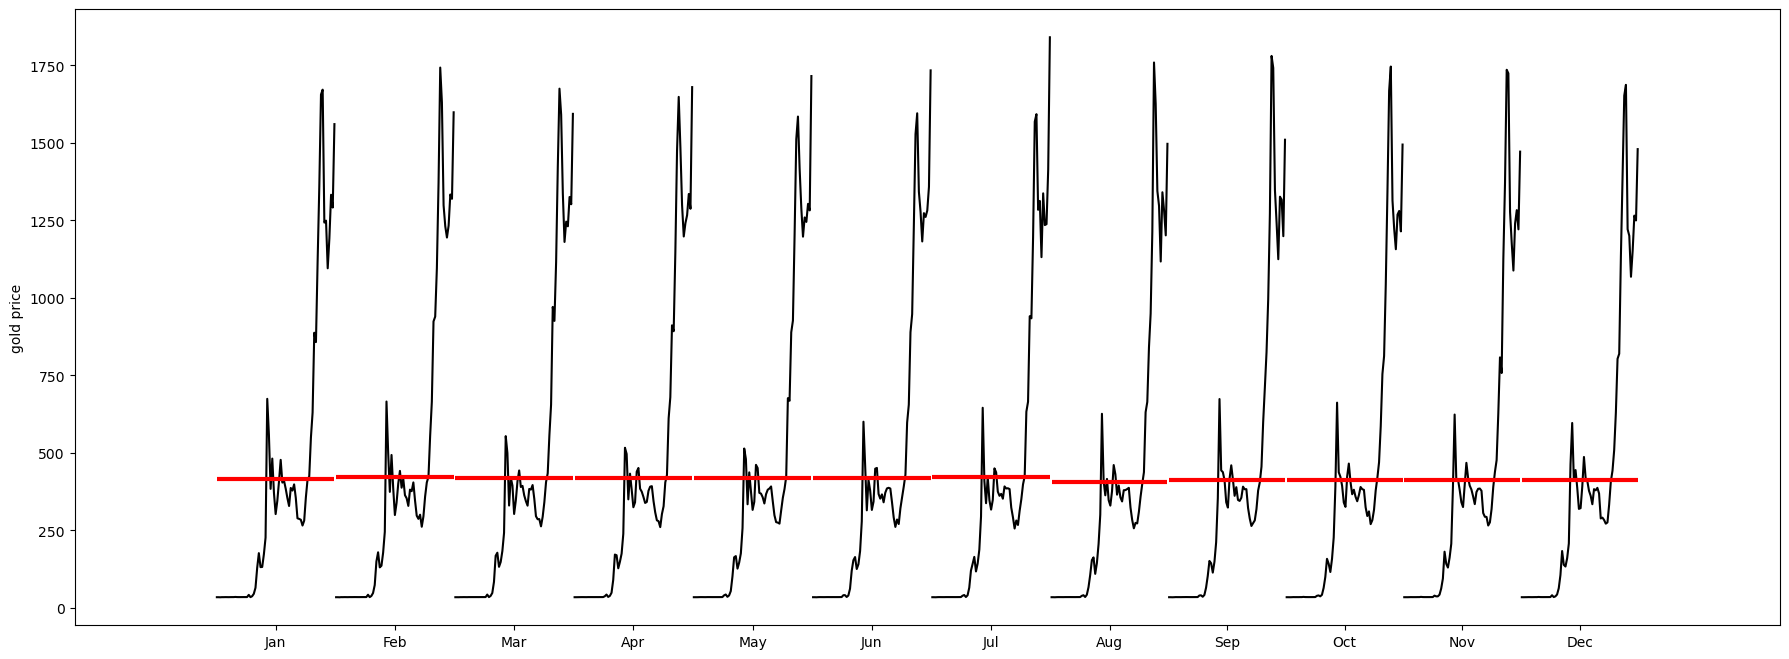

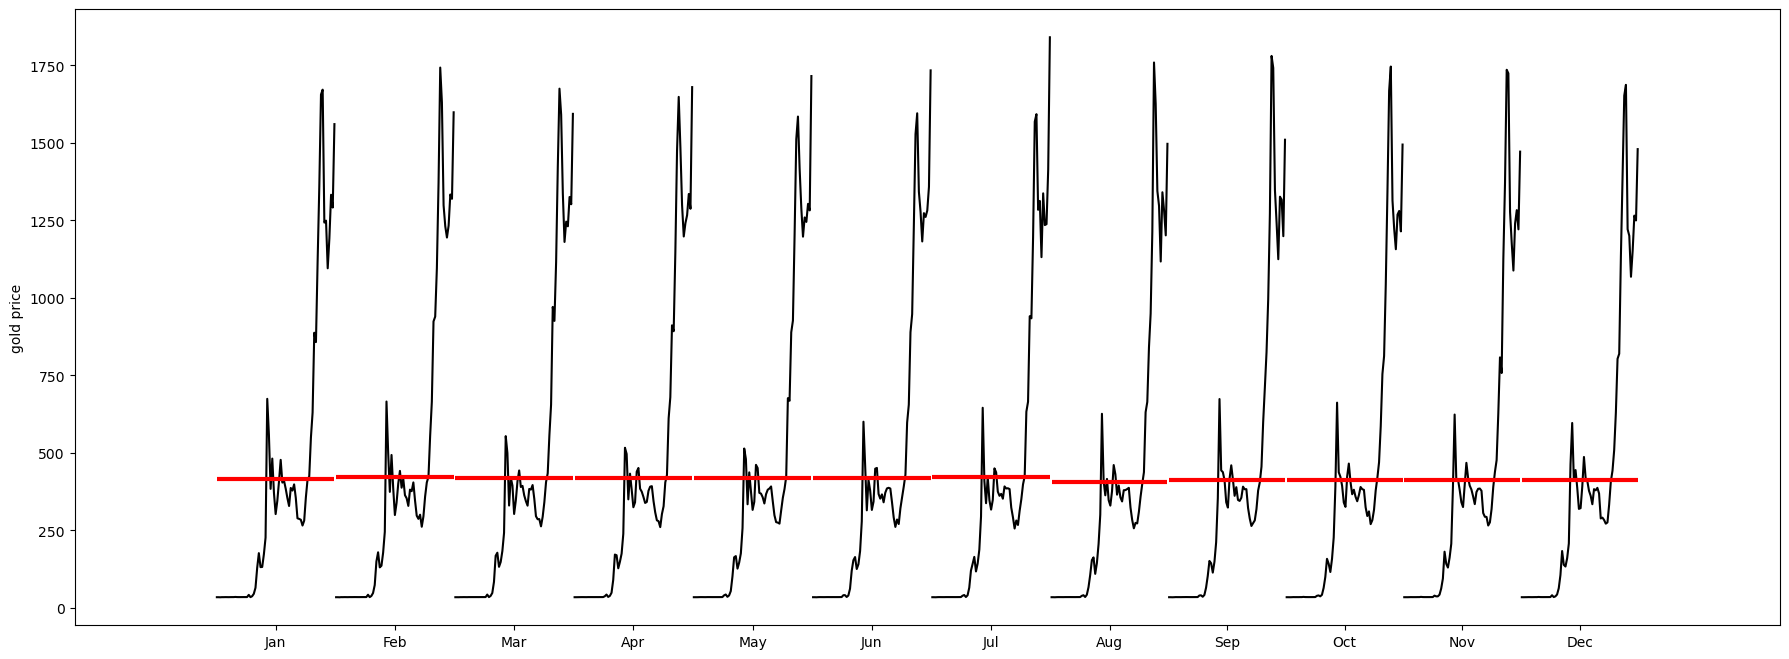

In [23]:
fig,ax=plt.subplots(figsize=(22,8))
month_plot(sales_main,ylabel='gold price',ax=ax)

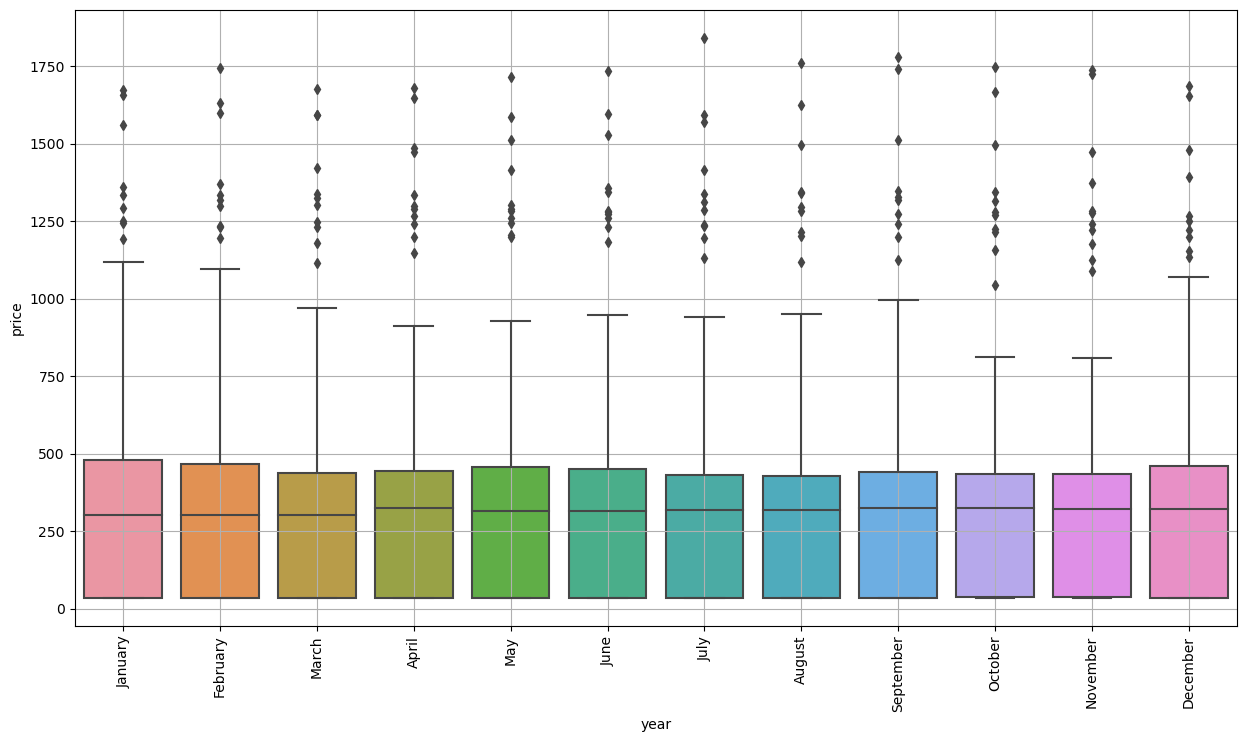

In [25]:
_,ax=plt.subplots(figsize=(15,8))
sns.boxplot(x=sales_main.index.month_name(),y=sales_main.values[:,0],ax=ax)
plt.xticks(rotation="vertical")
plt.xlabel("year")
plt.ylabel("price")
plt.grid()
plt.show()

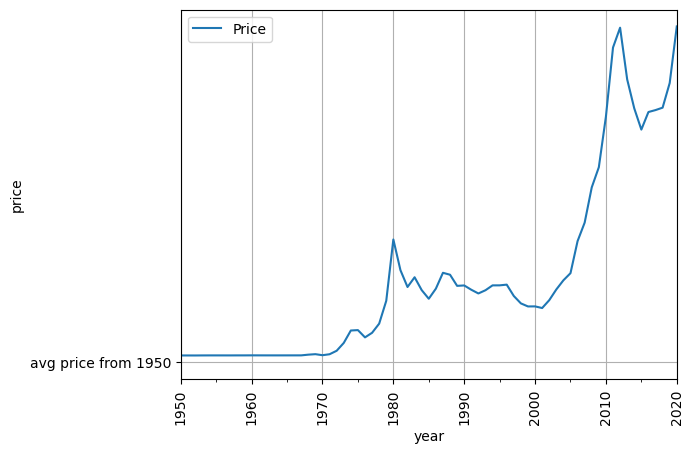

In [26]:
sales_main_yearly_sum=sales_main.resample("A").mean()
sales_main_yearly_sum.plot()
plt.plot("avg price from 1950")
plt.xticks(rotation="vertical")
plt.xlabel("year")
plt.ylabel("price")
plt.grid()
plt.show()

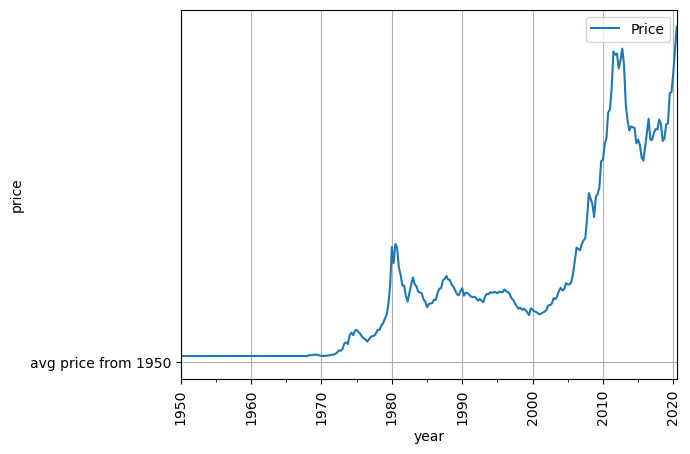

In [28]:
sales_main_quarterly_sum=sales_main.resample("Q").mean()
sales_main_quarterly_sum.plot()
plt.plot("avg price from 1950")
plt.xticks(rotation="vertical")
plt.xlabel("year")
plt.ylabel("price")
plt.grid()
plt.show()

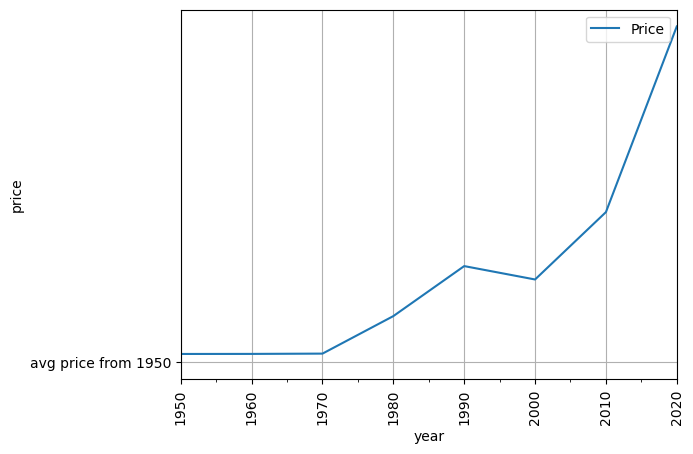

In [29]:
sales_main_10Y_sum=sales_main.resample("10Y").mean()
sales_main_10Y_sum.plot()
plt.plot("avg price from 1950")
plt.xticks(rotation="vertical")
plt.xlabel("year")
plt.ylabel("price")
plt.grid()
plt.show()

In [38]:
sales_1=sales_main.groupby(sales_main.index.year).mean().rename(columns={"Price":"Mean"})
sales_1=sales_1.merge(sales_main.groupby(sales_main.index.year).std().rename(columns={"Price":"Std"}),left_index=True,right_index=True)
sales_1["Cov_pct"]=((sales_1["Std"]/sales_1["Mean"])*100).round(2)
sales_1.head()

,Mean,Std,Cov_pct
month,,,
1950,34.729167,0.002887,0.01
1951,34.717500,0.020057,0.06
1952,34.628333,0.117538,0.34
1953,34.879167,0.056481,0.16
1954,35.020000,0.082792,0.24


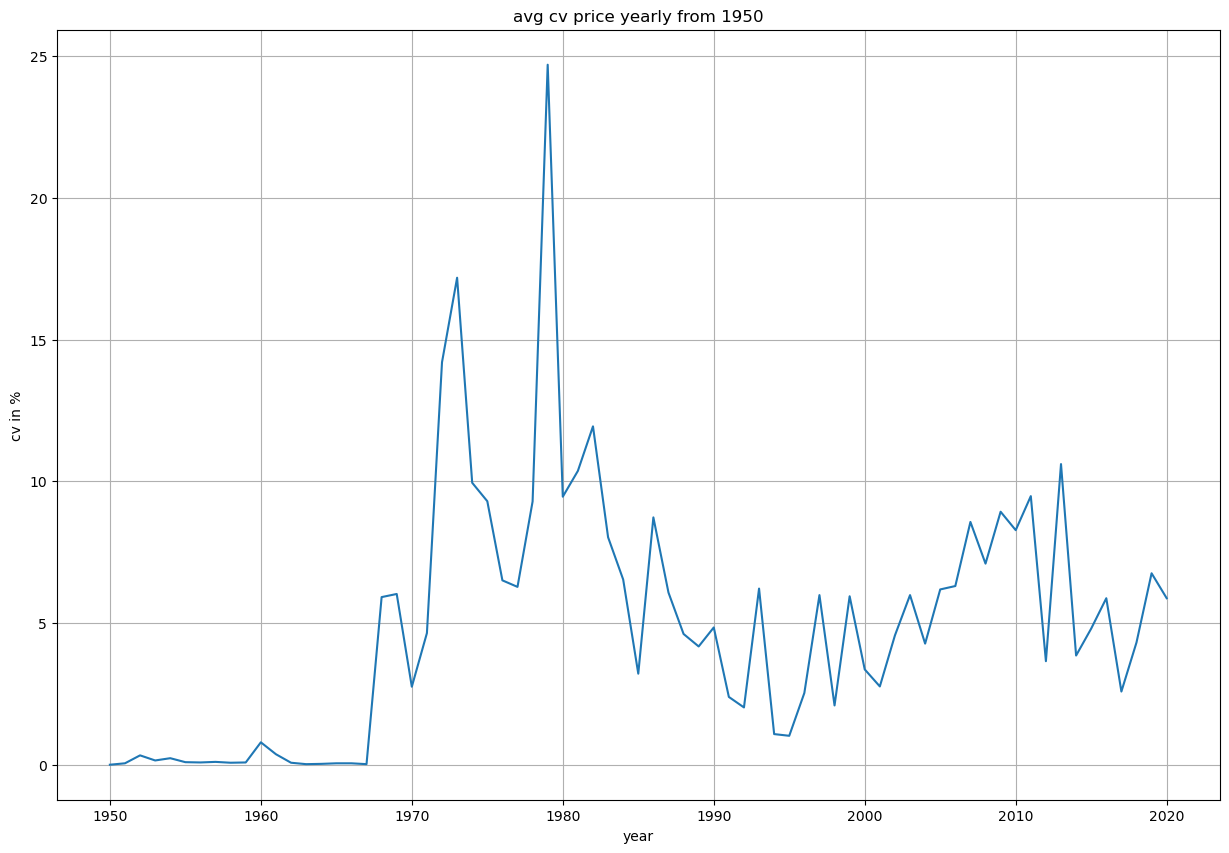

In [40]:
fig,ax=plt.subplots(figsize=(15,10))
sales_1["Cov_pct"].plot()
plt.title("avg cv price yearly from 1950")
plt.xlabel("year")
plt.ylabel("cv in %")
plt.grid()
plt.show()

In [42]:
train=sales_main[sales_main.index.year<=2015]
test=sales_main[sales_main.index.year>2015]

In [43]:
print(train.shape)

(792, 1)


In [44]:
print(test.shape)

(55, 1)


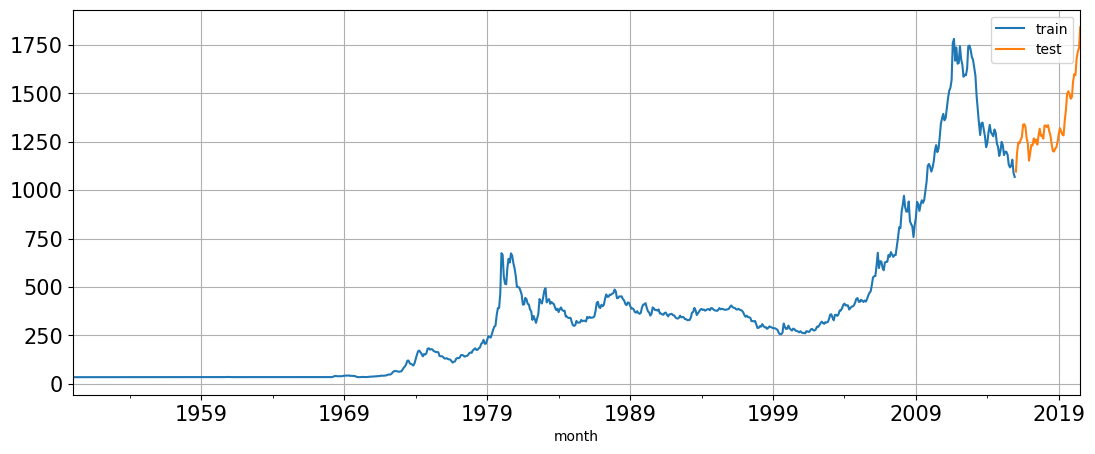

In [46]:
train["Price"].plot(figsize=(13,5),fontsize=15)
test["Price"].plot(figsize=(13,5),fontsize=15)
plt.grid()
plt.legend(["train","test"])
plt.show()

In [47]:
train_times=[i+1 for i in range(len(train))]
test_times=[i+len(train)+1 for i in range(len(test))]


In [48]:
lr_train=train.copy()
lr_test=test.copy()

In [52]:
lr_train["time"]=train_times
lr_test["time"]=test_times

In [50]:
lin=LinearRegression()
lin.fit(lr_train[["time"]],lr_train["Price"].values)

LinearRegression()

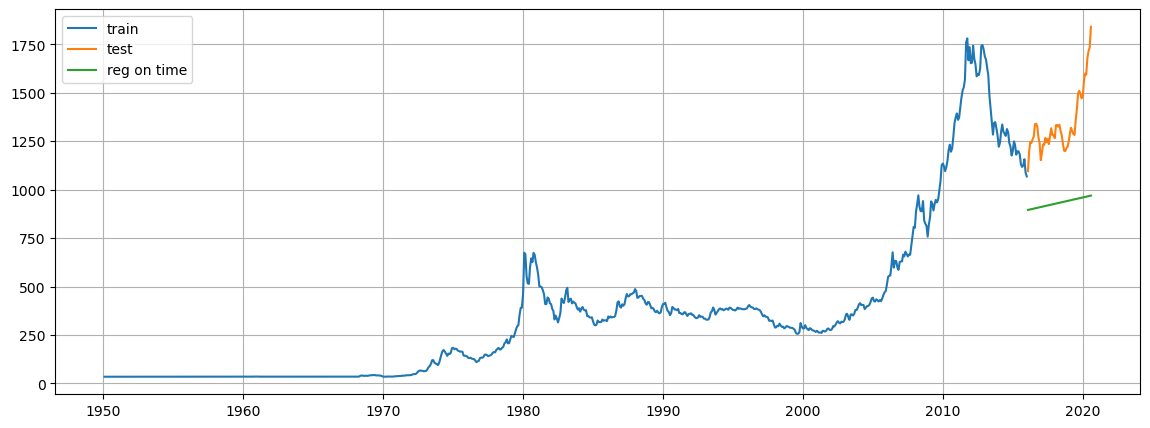

In [57]:
test_predictions_models=lin.predict(lr_test[["time"]])
lr_test["forecast"]=test_predictions_models
plt.figure(figsize=(14,5))
plt.plot(train["Price"],label="train")
plt.plot(test["Price"],label="test")
plt.plot(lr_test["forecast"],label="reg on time")
plt.grid()
plt.legend(loc="best")
plt.show()

In [59]:
def mape(Actual,pred):
    return round((np.mean(abs(Actual-pred)/Actual))*100,2)

In [60]:
mape_model1_test=mape(test["Price"].values,test_predictions_models)
mape_model1_test

29.76

In [63]:
final_model=ExponentialSmoothing(sales_main,trend="additive",
                                seasonal="additive").fit(smoothing_level=0.4,
                                                        smoothing_trend=0.3,
                                                        smoothing_seasonal=0.6)

In [65]:
Mape_final_model=mape(sales_main["Price"].values,final_model.fittedvalues)
Mape_final_model

17.24

In [66]:
predicitions=final_model.forecast(steps=len(test))

In [68]:
sales_pred=pd.DataFrame({"Low Ci":predicitions-1.96*np.std(final_model.resid,ddof=1),
                        "predction":predicitions,
                        "Upper CI":predicitions+1.96*np.std(final_model.resid,ddof=1)})
sales_pred

,Low Ci,predction,Upper CI
2020-08-31,1684.718274,1792.869246,1901.020219
2020-09-30,1615.301815,1723.452788,1831.603760
2020-10-31,1538.560879,1646.711851,1754.862823
2020-11-30,1476.748832,1584.899804,1693.050776
2020-12-31,1459.315210,1567.466182,1675.617154
2021-01-31,1514.403893,1622.554865,1730.705837
2021-02-28,1545.337867,1653.488839,1761.639811
2021-03-31,1556.749789,1664.900761,1773.051733
2021-04-30,1648.295729,1756.446701,1864.597673
2021-05-31,1694.212521,1802.363493,1910.514465


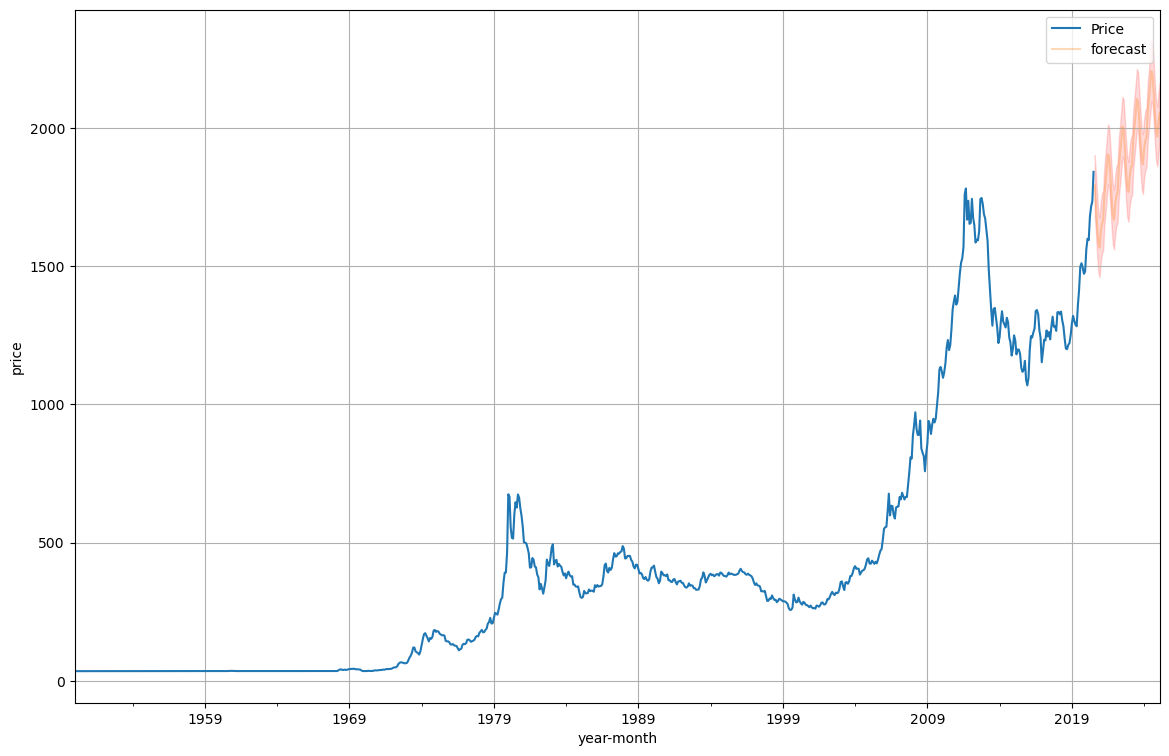

In [69]:
ax=sales_main.plot(label="Actual",figsize=(14,9))
sales_pred["predction"].plot(ax=ax,label="forecast",alpha=0.3)
ax.fill_between(sales_pred.index,sales_pred["Low Ci"],sales_pred["Upper CI"],color="r",alpha=0.15)
ax.set_xlabel("year-month")
ax.set_ylabel("price")
plt.legend(loc="best")
plt.grid()
plt.show()